In [0]:
!nvidia-smi

Tue Dec 10 18:42:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!ps -aux | grep python

root          21  2.2  0.7 401868 98644 ?        Sl   18:41   0:01 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         126 26.8  1.1 644096 151128 ?       Ssl  18:42   0:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-4d19c77d-fae2-4006-ad01-5d8f9a159ac5.json
root         145  0.0  0.0  39196  6464 ?        S    18:42   0:00 /bin/bash -c ps -aux | grep python
root         147  0.0  0.0  38572  5532 ?        S    18:42   0:00 grep python


In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import shutil
from torchvision import models
import torch.nn as nn
import torch
import json
import time
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from zipfile import ZipFile 
from keras.preprocessing.image import load_img, save_img, img_to_array
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with ZipFile("/content/gdrive/My Drive/Painting Dataset/train.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content') 
with ZipFile("/content/gdrive/My Drive/Painting Dataset/val.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content')    

In [0]:
train_directory = 'train'
val_directory = 'val'
preprocess = transforms.Compose([
              transforms.RandomResizedCrop(224), # random resized crop is used 
                                                 # for data augmentation
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
train_data = ImageFolder(train_directory, transform=preprocess)

val_data = ImageFolder(val_directory, transform=preprocess)

In [0]:
n_category = 50
# Resnet 18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, n_category)
# Resnet 50
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, n_category)
# Resnet 101
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(2048, n_category)
# GoogleNet
googleNet = models.googlenet(pretrained=True)
googleNet.fc = nn.Linear(1024, n_category)
# VGG 11 with batch normalization
vgg11 = models.vgg11_bn(pretrained=False)
vgg11.classifier[6] = nn.Linear(4096, n_category)
# VGG 19 with batch normalization
vgg19 = models.vgg19_bn(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, n_category)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 342MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 240MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 277MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 121MB/s]
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 117MB/s]


In [0]:
!pip install tqdm --upgrade

     |████████████████████████████████| 61kB 2.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score
def train(classifier, criterion, optimizer, trainLoader, device):
    epoch_loss = 0
    epoch_correct = 0
    classifier.train()
    record_pred = torch.FloatTensor().cpu()
    record_gt = torch.LongTensor().cpu()
    for i, (x, y) in tqdm(enumerate(trainLoader)):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = classifier(x)
        loss = criterion(predictions, y)
        # print('predictions.size()',predictions.size())
        epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()

        record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
        record_gt = torch.cat([record_gt, y.cpu()], dim=0)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    record_pred = record_pred.view(-1)
    record_gt = record_gt.view(-1)
    f1 = f1_score(record_gt, record_pred, average='weighted')
    precision = precision_score(record_gt, record_pred, average='weighted')
    recall = recall_score(record_gt, record_pred, average='weighted')
    print('Train f1', f1)
    print('Train precision', precision)
    print('Train recall', recall)
    return epoch_loss / len(trainLoader.dataset), epoch_correct / len(trainLoader.dataset), f1, precision, recall

def evaluate(classifier, criterion, optimizer, validLoader, device):
  epoch_loss = 0
  epoch_correct = 0
  classifier.eval()
  record_pred = torch.FloatTensor().cpu()
  record_gt = torch.LongTensor().cpu()
  with torch.no_grad():
      for i, (x, y) in tqdm(enumerate(validLoader)):
          x, y = x.to(device), y.to(device)

          predictions = classifier(x)
          
          loss = criterion(predictions, y)
          record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
          record_gt = torch.cat([record_gt, y.cpu()], dim=0)

          epoch_loss += loss.item()
          epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()
      record_pred = record_pred.view(-1)
      record_gt = record_gt.view(-1)
      f1 = f1_score(record_gt, record_pred, average='weighted')
      precision = precision_score(record_gt, record_pred, average='weighted')
      recall = recall_score(record_gt, record_pred, average='weighted')
      print('Val f1', f1)
      print('Val precision', precision)
      print('Val recall', recall)
  return epoch_loss / len(validLoader.dataset), epoch_correct / len(validLoader.dataset)

def plot_result(train_acc, val_acc, train_loss, val_loss):
  epochs = np.arange(0, 60)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=600)
  ax1.set_title('Train and Validation Accuracy over Epochs')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.plot(epochs, train_acc, label='training accuracy')
  ax1.plot(epochs, val_acc, label='validation accuracy')
  ax1.legend()

  ax2.set_title('Train and Validation Loss over Epochs')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.plot(epochs, train_loss, label='training loss')
  ax2.plot(epochs, val_loss, label='validation loss')
  ax2.legend()
  fig.savefig('googleNet_loss_acc.png', dpi=600)

In [0]:
def train_model(classifier, criterion, optimizer, 
                trainSet, testSet, scheduler=None, n_epochs = 60):
    params = {  
        'batch_size':64,
        'shuffle':True,
        'num_workers':0,
    }
    train_ls_acc, valid_ls_acc = [], []
    for epoch in range(n_epochs):
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_lr())

        train_loader = DataLoader(trainSet, **params)
        val_loader = DataLoader(testSet, **params)

        start_time = time.time()
        
        train_loss, train_acc, f1_t, p_t, r_t = train(classifier, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = evaluate(classifier, criterion, optimizer, val_loader, device)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        epoch_mins = int(elapsed_time/60)
        epoch_secs = int(elapsed_time - epoch_mins*60)
        
        train_ls_acc.append((train_loss, train_acc))
        valid_ls_acc.append((valid_loss, valid_acc))
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return train_ls_acc, valid_ls_acc

In [0]:
from torch.optim.lr_scheduler import StepLR
model = googleNet.to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size = 8, gamma = 0.96)
train_ls_acc, valid_ls_acc = train_model(model, criterion, optimizer, train_data, val_data, scheduler=scheduler)

Epoch: 0 LR: [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Train f1 0.0928968716557591
Train precision 0.12824851084353744
Train recall 0.169404973357016


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Val f1 0.1646007322784042
Val precision 0.23664976359455356
Val recall 0.26715976331360947
Epoch: 01 | Epoch Time: 6m 2s
	Train Loss: 0.053 | Train Acc: 16.94%
	 Val. Loss: 0.048 |  Val. Acc: 26.72%
Epoch: 1 LR: [0.001]



Train f1 0.22671717609470543
Train precision 0.34775496734708167
Train recall 0.31534931912374187



Val f1 0.28081516087295294
Val precision 0.29537030795578834
Val recall 0.3668639053254438
Epoch: 02 | Epoch Time: 5m 21s
	Train Loss: 0.044 | Train Acc: 31.53%
	 Val. Loss: 0.040 |  Val. Acc: 36.69%
Epoch: 2 LR: [0.001]



Train f1 0.340408330431427
Train precision 0.41033752092304243
Train recall 0.41437240970988753



Val f1 0.3665581810258443
Val precision 0.40182641817365783
Val recall 0.43757396449704145
Epoch: 03 | Epoch Time: 5m 24s
	Train Loss: 0.037 | Train Acc: 41.44%
	 Val. Loss: 0.034 |  Val. Acc: 43.76%
Epoch: 3 LR: [0.001]



Train f1 0.42294875513122526
Train precision 0.4803113368101955
Train recall 0.4854203670811131



Val f1 0.43059788713799313
Val precision 0.4702560147072655
Val recall 0.48668639053254437
Epoch: 04 | Epoch Time: 5m 20s
	Train Loss: 0.032 | Train Acc: 48.54%
	 Val. Loss: 0.030 |  Val. Acc: 48.67%
Epoch: 4 LR: [0.001]



Train f1 0.4826396889143033
Train precision 0.5226321229111973
Train recall 0.5320455891059799



Val f1 0.4882161760738239
Val precision 0.4933045138518327
Val recall 0.5328402366863906
Epoch: 05 | Epoch Time: 5m 28s
	Train Loss: 0.028 | Train Acc: 53.20%
	 Val. Loss: 0.028 |  Val. Acc: 53.28%
Epoch: 5 LR: [0.001]



Train f1 0.532042357212513
Train precision 0.5505283168040151
Train recall 0.5739342806394316



Val f1 0.5401116272061481
Val precision 0.564271613499565
Val recall 0.5760355029585799
Epoch: 06 | Epoch Time: 5m 20s
	Train Loss: 0.025 | Train Acc: 57.39%
	 Val. Loss: 0.025 |  Val. Acc: 57.60%
Epoch: 6 LR: [0.001]



Train f1 0.5706071696268898
Train precision 0.593672093440707
Train recall 0.6070899940793368



Val f1 0.5563721202124607
Val precision 0.5662281564790588
Val recall 0.5881656804733728
Epoch: 07 | Epoch Time: 5m 19s
	Train Loss: 0.023 | Train Acc: 60.71%
	 Val. Loss: 0.024 |  Val. Acc: 58.82%
Epoch: 7 LR: [0.00096]



Train f1 0.6044309285395508
Train precision 0.623985661491329
Train recall 0.6335849615156898



Val f1 0.5848071021250197
Val precision 0.6067987940764259
Val recall 0.6103550295857988
Epoch: 08 | Epoch Time: 5m 20s
	Train Loss: 0.021 | Train Acc: 63.36%
	 Val. Loss: 0.022 |  Val. Acc: 61.04%
Epoch: 8 LR: [0.00096]



Train f1 0.6313064213851095
Train precision 0.6493555723003831
Train recall 0.6573416222616933



Val f1 0.6097385209615634
Val precision 0.6336505635400579
Val recall 0.6319526627218935
Epoch: 09 | Epoch Time: 5m 18s
	Train Loss: 0.020 | Train Acc: 65.73%
	 Val. Loss: 0.021 |  Val. Acc: 63.20%
Epoch: 9 LR: [0.00096]



Train f1 0.6558215607188751
Train precision 0.6722232646854522
Train recall 0.6776939017169923



Val f1 0.6325629575138912
Val precision 0.6386867920502056
Val recall 0.6514792899408284
Epoch: 10 | Epoch Time: 5m 22s
	Train Loss: 0.018 | Train Acc: 67.77%
	 Val. Loss: 0.020 |  Val. Acc: 65.15%
Epoch: 10 LR: [0.00096]



Train f1 0.6815849970808013
Train precision 0.690687423288187
Train recall 0.7006364712847839



Val f1 0.6456553466268633
Val precision 0.655957417359241
Val recall 0.6633136094674557
Epoch: 11 | Epoch Time: 5m 25s
	Train Loss: 0.017 | Train Acc: 70.06%
	 Val. Loss: 0.019 |  Val. Acc: 66.33%
Epoch: 11 LR: [0.00096]



Train f1 0.6987079572276679
Train precision 0.7126247471656626
Train recall 0.7145500296033156



Val f1 0.6642686703721811
Val precision 0.6801312026655155
Val recall 0.6789940828402367
Epoch: 12 | Epoch Time: 5m 29s
	Train Loss: 0.016 | Train Acc: 71.46%
	 Val. Loss: 0.019 |  Val. Acc: 67.90%
Epoch: 12 LR: [0.00096]



Train f1 0.7194690451594419
Train precision 0.7303547280398401
Train recall 0.7324600355239786



Val f1 0.6581576142654032
Val precision 0.6657887047910896
Val recall 0.6751479289940828
Epoch: 13 | Epoch Time: 5m 26s
	Train Loss: 0.015 | Train Acc: 73.25%
	 Val. Loss: 0.018 |  Val. Acc: 67.51%
Epoch: 13 LR: [0.00096]



Train f1 0.7319843194493617
Train precision 0.741323902223922
Train recall 0.7441533451746596



Val f1 0.6736218271204198
Val precision 0.6804717981965682
Val recall 0.6890532544378698
Epoch: 14 | Epoch Time: 5m 26s
	Train Loss: 0.015 | Train Acc: 74.42%
	 Val. Loss: 0.018 |  Val. Acc: 68.91%
Epoch: 14 LR: [0.00096]



Train f1 0.7483743860193691
Train precision 0.7551362239153725
Train recall 0.7590290112492599



Val f1 0.6799611597778791
Val precision 0.6904454888942022
Val recall 0.6896449704142011
Epoch: 15 | Epoch Time: 5m 30s
	Train Loss: 0.014 | Train Acc: 75.90%
	 Val. Loss: 0.017 |  Val. Acc: 68.96%
Epoch: 15 LR: [0.0009216]



Train f1 0.7565201756772248
Train precision 0.761332526040456
Train recall 0.7662818235642392



Val f1 0.692751689851266
Val precision 0.6993058543994931
Val recall 0.7023668639053254
Epoch: 16 | Epoch Time: 5m 28s
	Train Loss: 0.013 | Train Acc: 76.63%
	 Val. Loss: 0.017 |  Val. Acc: 70.24%
Epoch: 16 LR: [0.0009216]



Train f1 0.766459715358943
Train precision 0.7704255198048912
Train recall 0.7748667850799289



Val f1 0.687777872077774
Val precision 0.700596456291891
Val recall 0.6964497041420118
Epoch: 17 | Epoch Time: 5m 24s
	Train Loss: 0.013 | Train Acc: 77.49%
	 Val. Loss: 0.017 |  Val. Acc: 69.64%
Epoch: 17 LR: [0.0009216]



Train f1 0.7786148251880414
Train precision 0.7825692539578752
Train recall 0.7855979869745412



Val f1 0.7030227862631898
Val precision 0.7144653776346572
Val recall 0.7124260355029586
Epoch: 18 | Epoch Time: 5m 25s
	Train Loss: 0.012 | Train Acc: 78.56%
	 Val. Loss: 0.016 |  Val. Acc: 71.24%
Epoch: 18 LR: [0.0009216]



Train f1 0.7907906251395737
Train precision 0.7941410489301064
Train recall 0.7975133214920072



Val f1 0.7062108420348188
Val precision 0.7151500527963619
Val recall 0.7115384615384616
Epoch: 19 | Epoch Time: 5m 26s
	Train Loss: 0.011 | Train Acc: 79.75%
	 Val. Loss: 0.016 |  Val. Acc: 71.15%
Epoch: 19 LR: [0.0009216]



Train f1 0.8007165502977966
Train precision 0.8022730490880873
Train recall 0.8064683244523386



Val f1 0.7066841040542916
Val precision 0.7195164042492891
Val recall 0.7121301775147929
Epoch: 20 | Epoch Time: 5m 24s
	Train Loss: 0.011 | Train Acc: 80.65%
	 Val. Loss: 0.016 |  Val. Acc: 71.21%
Epoch: 20 LR: [0.0009216]



Train f1 0.8083303392430755
Train precision 0.811840233007234
Train recall 0.8133510953226761



Val f1 0.7255522100390198
Val precision 0.729876978573715
Val recall 0.729585798816568
Epoch: 21 | Epoch Time: 5m 25s
	Train Loss: 0.010 | Train Acc: 81.34%
	 Val. Loss: 0.016 |  Val. Acc: 72.96%
Epoch: 21 LR: [0.0009216]



Train f1 0.8138744481038725
Train precision 0.8150883089475784
Train recall 0.8187537004144464



Val f1 0.7094779964832387
Val precision 0.7202228953823717
Val recall 0.7165680473372781
Epoch: 22 | Epoch Time: 5m 25s
	Train Loss: 0.010 | Train Acc: 81.88%
	 Val. Loss: 0.016 |  Val. Acc: 71.66%
Epoch: 22 LR: [0.0009216]



Train f1 0.8251047779586483
Train precision 0.825698174884068
Train recall 0.8296329188869154



Val f1 0.7233745703314783
Val precision 0.7298493973555811
Val recall 0.7284023668639054
Epoch: 23 | Epoch Time: 5m 27s
	Train Loss: 0.010 | Train Acc: 82.96%
	 Val. Loss: 0.015 |  Val. Acc: 72.84%
Epoch: 23 LR: [0.0008847359999999999]



Train f1 0.8254345639335925
Train precision 0.8264278199666938
Train recall 0.8298549437537004



Val f1 0.723529115176022
Val precision 0.7283558438726894
Val recall 0.7310650887573964
Epoch: 24 | Epoch Time: 5m 25s
	Train Loss: 0.009 | Train Acc: 82.99%
	 Val. Loss: 0.015 |  Val. Acc: 73.11%
Epoch: 24 LR: [0.0008847359999999999]



Train f1 0.8353831619909717
Train precision 0.8374855282816736
Train recall 0.8393280047365305



Val f1 0.7309255200165431
Val precision 0.7367208153148421
Val recall 0.7355029585798817
Epoch: 25 | Epoch Time: 5m 25s
	Train Loss: 0.009 | Train Acc: 83.93%
	 Val. Loss: 0.015 |  Val. Acc: 73.55%
Epoch: 25 LR: [0.0008847359999999999]



Train f1 0.8442985176148305
Train precision 0.8458971105474049
Train recall 0.8475429248075784



Val f1 0.7210292308215626
Val precision 0.7264691113350514
Val recall 0.7260355029585799
Epoch: 26 | Epoch Time: 5m 24s
	Train Loss: 0.008 | Train Acc: 84.75%
	 Val. Loss: 0.015 |  Val. Acc: 72.60%
Epoch: 26 LR: [0.0008847359999999999]



Train f1 0.8468204812344885
Train precision 0.848046400498424
Train recall 0.8499851983422143



Val f1 0.7369163584471026
Val precision 0.74209532682634
Val recall 0.7414201183431952
Epoch: 27 | Epoch Time: 5m 25s
	Train Loss: 0.008 | Train Acc: 85.00%
	 Val. Loss: 0.015 |  Val. Acc: 74.14%
Epoch: 27 LR: [0.0008847359999999999]



Train f1 0.853103833363266
Train precision 0.8538633885652579
Train recall 0.8559798697454115



Val f1 0.7329272530638327
Val precision 0.7353215887638599
Val recall 0.7384615384615385
Epoch: 28 | Epoch Time: 5m 27s
	Train Loss: 0.008 | Train Acc: 85.60%
	 Val. Loss: 0.014 |  Val. Acc: 73.85%
Epoch: 28 LR: [0.0008847359999999999]



Train f1 0.8607897430177416
Train precision 0.8620416945214049
Train recall 0.8636027235050325



Val f1 0.7409300560218604
Val precision 0.7469102233841759
Val recall 0.7446745562130177
Epoch: 29 | Epoch Time: 5m 25s
	Train Loss: 0.008 | Train Acc: 86.36%
	 Val. Loss: 0.014 |  Val. Acc: 74.47%
Epoch: 29 LR: [0.0008847359999999999]



Train f1 0.8620304062754828
Train precision 0.8621913437622852
Train recall 0.8643428063943162



Val f1 0.7395203457114783
Val precision 0.7473260402019894
Val recall 0.744378698224852
Epoch: 30 | Epoch Time: 5m 24s
	Train Loss: 0.008 | Train Acc: 86.43%
	 Val. Loss: 0.014 |  Val. Acc: 74.44%
Epoch: 30 LR: [0.0008847359999999999]



Train f1 0.865486801915233
Train precision 0.8658580242412015
Train recall 0.8678211959739491



Val f1 0.7431647624797125
Val precision 0.7477631974087602
Val recall 0.7473372781065089
Epoch: 31 | Epoch Time: 5m 23s
	Train Loss: 0.007 | Train Acc: 86.78%
	 Val. Loss: 0.014 |  Val. Acc: 74.73%
Epoch: 31 LR: [0.0008493465599999999]



Train f1 0.869290082468885
Train precision 0.8709420632673683
Train recall 0.8715956187092955



Val f1 0.7456154211376973
Val precision 0.7524190154397251
Val recall 0.7497041420118343
Epoch: 32 | Epoch Time: 5m 25s
	Train Loss: 0.007 | Train Acc: 87.16%
	 Val. Loss: 0.014 |  Val. Acc: 74.97%
Epoch: 32 LR: [0.0008493465599999999]



Train f1 0.8781331292017824
Train precision 0.8786534999474657
Train recall 0.8802545885139136



Val f1 0.7439497778280443
Val precision 0.7491754552923484
Val recall 0.7488165680473373
Epoch: 33 | Epoch Time: 5m 26s
	Train Loss: 0.007 | Train Acc: 88.03%
	 Val. Loss: 0.014 |  Val. Acc: 74.88%
Epoch: 33 LR: [0.0008493465599999999]



Train f1 0.8841866760565168
Train precision 0.8842855250256636
Train recall 0.8858792184724689



Val f1 0.7401100262474167
Val precision 0.745753587537804
Val recall 0.7446745562130177
Epoch: 34 | Epoch Time: 5m 26s
	Train Loss: 0.006 | Train Acc: 88.59%
	 Val. Loss: 0.014 |  Val. Acc: 74.47%
Epoch: 34 LR: [0.0008493465599999999]



Train f1 0.8806737181607995
Train precision 0.8809371960501882
Train recall 0.8824748371817643



Val f1 0.7416968068949666
Val precision 0.7457618282550987
Val recall 0.7467455621301775
Epoch: 35 | Epoch Time: 5m 26s
	Train Loss: 0.007 | Train Acc: 88.25%
	 Val. Loss: 0.014 |  Val. Acc: 74.67%
Epoch: 35 LR: [0.0008493465599999999]



Train f1 0.885307117758629
Train precision 0.8858856180528336
Train recall 0.8870633510953226



Val f1 0.7525807924735821
Val precision 0.7568309291524694
Val recall 0.7541420118343195
Epoch: 36 | Epoch Time: 5m 26s
	Train Loss: 0.006 | Train Acc: 88.71%
	 Val. Loss: 0.014 |  Val. Acc: 75.41%
Epoch: 36 LR: [0.0008493465599999999]



Train f1 0.8906359331753371
Train precision 0.8908088410452876
Train recall 0.8920959147424512



Val f1 0.7475241308734925
Val precision 0.7507247332249904
Val recall 0.7502958579881657
Epoch: 37 | Epoch Time: 5m 28s
	Train Loss: 0.006 | Train Acc: 89.21%
	 Val. Loss: 0.014 |  Val. Acc: 75.03%
Epoch: 37 LR: [0.0008493465599999999]



Train f1 0.8925249158482019
Train precision 0.8929352781884807
Train recall 0.8938721136767318



Val f1 0.7534268942598848
Val precision 0.7571619578123943
Val recall 0.7562130177514793
Epoch: 38 | Epoch Time: 5m 27s
	Train Loss: 0.006 | Train Acc: 89.39%
	 Val. Loss: 0.014 |  Val. Acc: 75.62%
Epoch: 38 LR: [0.0008493465599999999]



Train f1 0.8953984513815377
Train precision 0.8955983729574649
Train recall 0.896388395500296



Val f1 0.7531485835022931
Val precision 0.7581716816574017
Val recall 0.7571005917159763
Epoch: 39 | Epoch Time: 5m 26s
	Train Loss: 0.006 | Train Acc: 89.64%
	 Val. Loss: 0.014 |  Val. Acc: 75.71%
Epoch: 39 LR: [0.0008153726975999999]



Train f1 0.8992270660464016
Train precision 0.8994567976555476
Train recall 0.9003848431024275



Val f1 0.7544349740134428
Val precision 0.7596130100902941
Val recall 0.7591715976331361
Epoch: 40 | Epoch Time: 5m 25s
	Train Loss: 0.006 | Train Acc: 90.04%
	 Val. Loss: 0.013 |  Val. Acc: 75.92%
Epoch: 40 LR: [0.0008153726975999999]



Train f1 0.902359077641272
Train precision 0.9023293827230391
Train recall 0.9035671995263469



Val f1 0.7560142447247796
Val precision 0.7611619522500614
Val recall 0.7585798816568048
Epoch: 41 | Epoch Time: 5m 25s
	Train Loss: 0.005 | Train Acc: 90.36%
	 Val. Loss: 0.014 |  Val. Acc: 75.86%
Epoch: 41 LR: [0.0008153726975999999]



Train f1 0.9022454505966981
Train precision 0.9025114383115141
Train recall 0.9033451746595619



Val f1 0.7572667564707969
Val precision 0.7623650441680372
Val recall 0.7579881656804733
Epoch: 42 | Epoch Time: 5m 25s
	Train Loss: 0.005 | Train Acc: 90.33%
	 Val. Loss: 0.014 |  Val. Acc: 75.80%
Epoch: 42 LR: [0.0008153726975999999]



Train f1 0.9090164978815226
Train precision 0.9092823356357214
Train recall 0.9100059206631143



Val f1 0.7634453199396195
Val precision 0.7684663542269634
Val recall 0.7665680473372781
Epoch: 43 | Epoch Time: 5m 28s
	Train Loss: 0.005 | Train Acc: 91.00%
	 Val. Loss: 0.013 |  Val. Acc: 76.66%
Epoch: 43 LR: [0.0008153726975999999]



Train f1 0.9070822737672175
Train precision 0.9073577624561188
Train recall 0.908303730017762



Val f1 0.7639549731304871
Val precision 0.7702243790720497
Val recall 0.7653846153846153
Epoch: 44 | Epoch Time: 5m 28s
	Train Loss: 0.005 | Train Acc: 90.83%
	 Val. Loss: 0.014 |  Val. Acc: 76.54%
Epoch: 44 LR: [0.0008153726975999999]



Train f1 0.9056796846188145
Train precision 0.9059801779662836
Train recall 0.9068235642391947



Val f1 0.7668868014123706
Val precision 0.7734596745900087
Val recall 0.7692307692307693
Epoch: 45 | Epoch Time: 5m 27s
	Train Loss: 0.005 | Train Acc: 90.68%
	 Val. Loss: 0.014 |  Val. Acc: 76.92%
Epoch: 45 LR: [0.0008153726975999999]



Train f1 0.9115371016857536
Train precision 0.9116285744688901
Train recall 0.9123001776198935



Val f1 0.7573469397995015
Val precision 0.7630083777254724
Val recall 0.7612426035502958
Epoch: 46 | Epoch Time: 5m 26s
	Train Loss: 0.005 | Train Acc: 91.23%
	 Val. Loss: 0.014 |  Val. Acc: 76.12%
Epoch: 46 LR: [0.0008153726975999999]



Train f1 0.9126446908597311
Train precision 0.9127489543683172
Train recall 0.9134103019538188



Val f1 0.7626753550361874
Val precision 0.7685816462076775
Val recall 0.7671597633136095
Epoch: 47 | Epoch Time: 5m 26s
	Train Loss: 0.005 | Train Acc: 91.34%
	 Val. Loss: 0.014 |  Val. Acc: 76.72%
Epoch: 47 LR: [0.0007827577896959999]



Train f1 0.9148419850758464
Train precision 0.9149328813404665
Train recall 0.9155565423327413



Val f1 0.7658232116306417
Val precision 0.7699533260809819
Val recall 0.7695266272189349
Epoch: 48 | Epoch Time: 5m 25s
	Train Loss: 0.005 | Train Acc: 91.56%
	 Val. Loss: 0.013 |  Val. Acc: 76.95%
Epoch: 48 LR: [0.0007827577896959999]



Train f1 0.9174460936616796
Train precision 0.9177412082768001
Train recall 0.9182208407341622



Val f1 0.7604888891594802
Val precision 0.7647892177269016
Val recall 0.7627218934911243
Epoch: 49 | Epoch Time: 5m 26s
	Train Loss: 0.005 | Train Acc: 91.82%
	 Val. Loss: 0.014 |  Val. Acc: 76.27%
Epoch: 49 LR: [0.0007827577896959999]



Train f1 0.9221328496544615
Train precision 0.9223174629245869
Train recall 0.9227353463587922



Val f1 0.7612895668706977
Val precision 0.767487174884496
Val recall 0.7633136094674556
Epoch: 50 | Epoch Time: 5m 27s
	Train Loss: 0.004 | Train Acc: 92.27%
	 Val. Loss: 0.014 |  Val. Acc: 76.33%
Epoch: 50 LR: [0.0007827577896959999]



Train f1 0.9216510719152725
Train precision 0.9219530839604035
Train recall 0.9222172883362937



Val f1 0.7679942764899078
Val precision 0.7750066427108159
Val recall 0.770414201183432
Epoch: 51 | Epoch Time: 5m 26s
	Train Loss: 0.004 | Train Acc: 92.22%
	 Val. Loss: 0.013 |  Val. Acc: 77.04%
Epoch: 51 LR: [0.0007827577896959999]



Train f1 0.9229930384677405
Train precision 0.9230062014383431
Train recall 0.9236234458259325



Val f1 0.7656898433804531
Val precision 0.7701846240234903
Val recall 0.7686390532544378
Epoch: 52 | Epoch Time: 5m 27s
	Train Loss: 0.004 | Train Acc: 92.36%
	 Val. Loss: 0.014 |  Val. Acc: 76.86%
Epoch: 52 LR: [0.0007827577896959999]



Train f1 0.9234414447662459
Train precision 0.9235611857641294
Train recall 0.9240674955595026



Val f1 0.7609464288783033
Val precision 0.7634903221227052
Val recall 0.7633136094674556
Epoch: 53 | Epoch Time: 5m 29s
	Train Loss: 0.004 | Train Acc: 92.41%
	 Val. Loss: 0.013 |  Val. Acc: 76.33%
Epoch: 53 LR: [0.0007827577896959999]



Train f1 0.9280143191333281
Train precision 0.92826341823591
Train recall 0.9285079928952042



Val f1 0.7664830405544502
Val precision 0.7711633873770046
Val recall 0.7698224852071006
Epoch: 54 | Epoch Time: 5m 28s
	Train Loss: 0.004 | Train Acc: 92.85%
	 Val. Loss: 0.014 |  Val. Acc: 76.98%
Epoch: 54 LR: [0.0007827577896959999]



Train f1 0.930042280868457
Train precision 0.9300994631620703
Train recall 0.9305802249851983



Val f1 0.7631743046276568
Val precision 0.7689201429410694
Val recall 0.7642011834319526
Epoch: 55 | Epoch Time: 5m 29s
	Train Loss: 0.004 | Train Acc: 93.06%
	 Val. Loss: 0.014 |  Val. Acc: 76.42%
Epoch: 55 LR: [0.0007514474781081599]



Train f1 0.9293855718545627
Train precision 0.9295619041807653
Train recall 0.9298401420959147



Val f1 0.7732165920477636
Val precision 0.7776786165685823
Val recall 0.7757396449704143
Epoch: 56 | Epoch Time: 5m 28s
	Train Loss: 0.004 | Train Acc: 92.98%
	 Val. Loss: 0.013 |  Val. Acc: 77.57%
Epoch: 56 LR: [0.0007514474781081599]



Train f1 0.9325773800723308
Train precision 0.9327007746458311
Train recall 0.9330224985198342



Val f1 0.7609074315411213
Val precision 0.7657857386665017
Val recall 0.7653846153846153
Epoch: 57 | Epoch Time: 5m 31s
	Train Loss: 0.004 | Train Acc: 93.30%
	 Val. Loss: 0.014 |  Val. Acc: 76.54%
Epoch: 57 LR: [0.0007514474781081599]



Train f1 0.9339048477422004
Train precision 0.9340409419979666
Train recall 0.9343546477205447



Val f1 0.7665784307096006
Val precision 0.7710454208525438
Val recall 0.7674556213017751
Epoch: 58 | Epoch Time: 5m 30s
	Train Loss: 0.004 | Train Acc: 93.44%
	 Val. Loss: 0.014 |  Val. Acc: 76.75%
Epoch: 58 LR: [0.0007514474781081599]



Train f1 0.9314394501807499
Train precision 0.9316310520064525
Train recall 0.9318383658969804



Val f1 0.7621145519187841
Val precision 0.7688576722101809
Val recall 0.7633136094674556
Epoch: 59 | Epoch Time: 5m 29s
	Train Loss: 0.004 | Train Acc: 93.18%
	 Val. Loss: 0.014 |  Val. Acc: 76.33%
Epoch: 59 LR: [0.0007514474781081599]



Train f1 0.9360837496726333
Train precision 0.9361607598125471
Train recall 0.9365008880994672



Val f1 0.7701004469801607
Val precision 0.7750806747353565
Val recall 0.770414201183432
Epoch: 60 | Epoch Time: 5m 30s
	Train Loss: 0.004 | Train Acc: 93.65%
	 Val. Loss: 0.013 |  Val. Acc: 77.04%


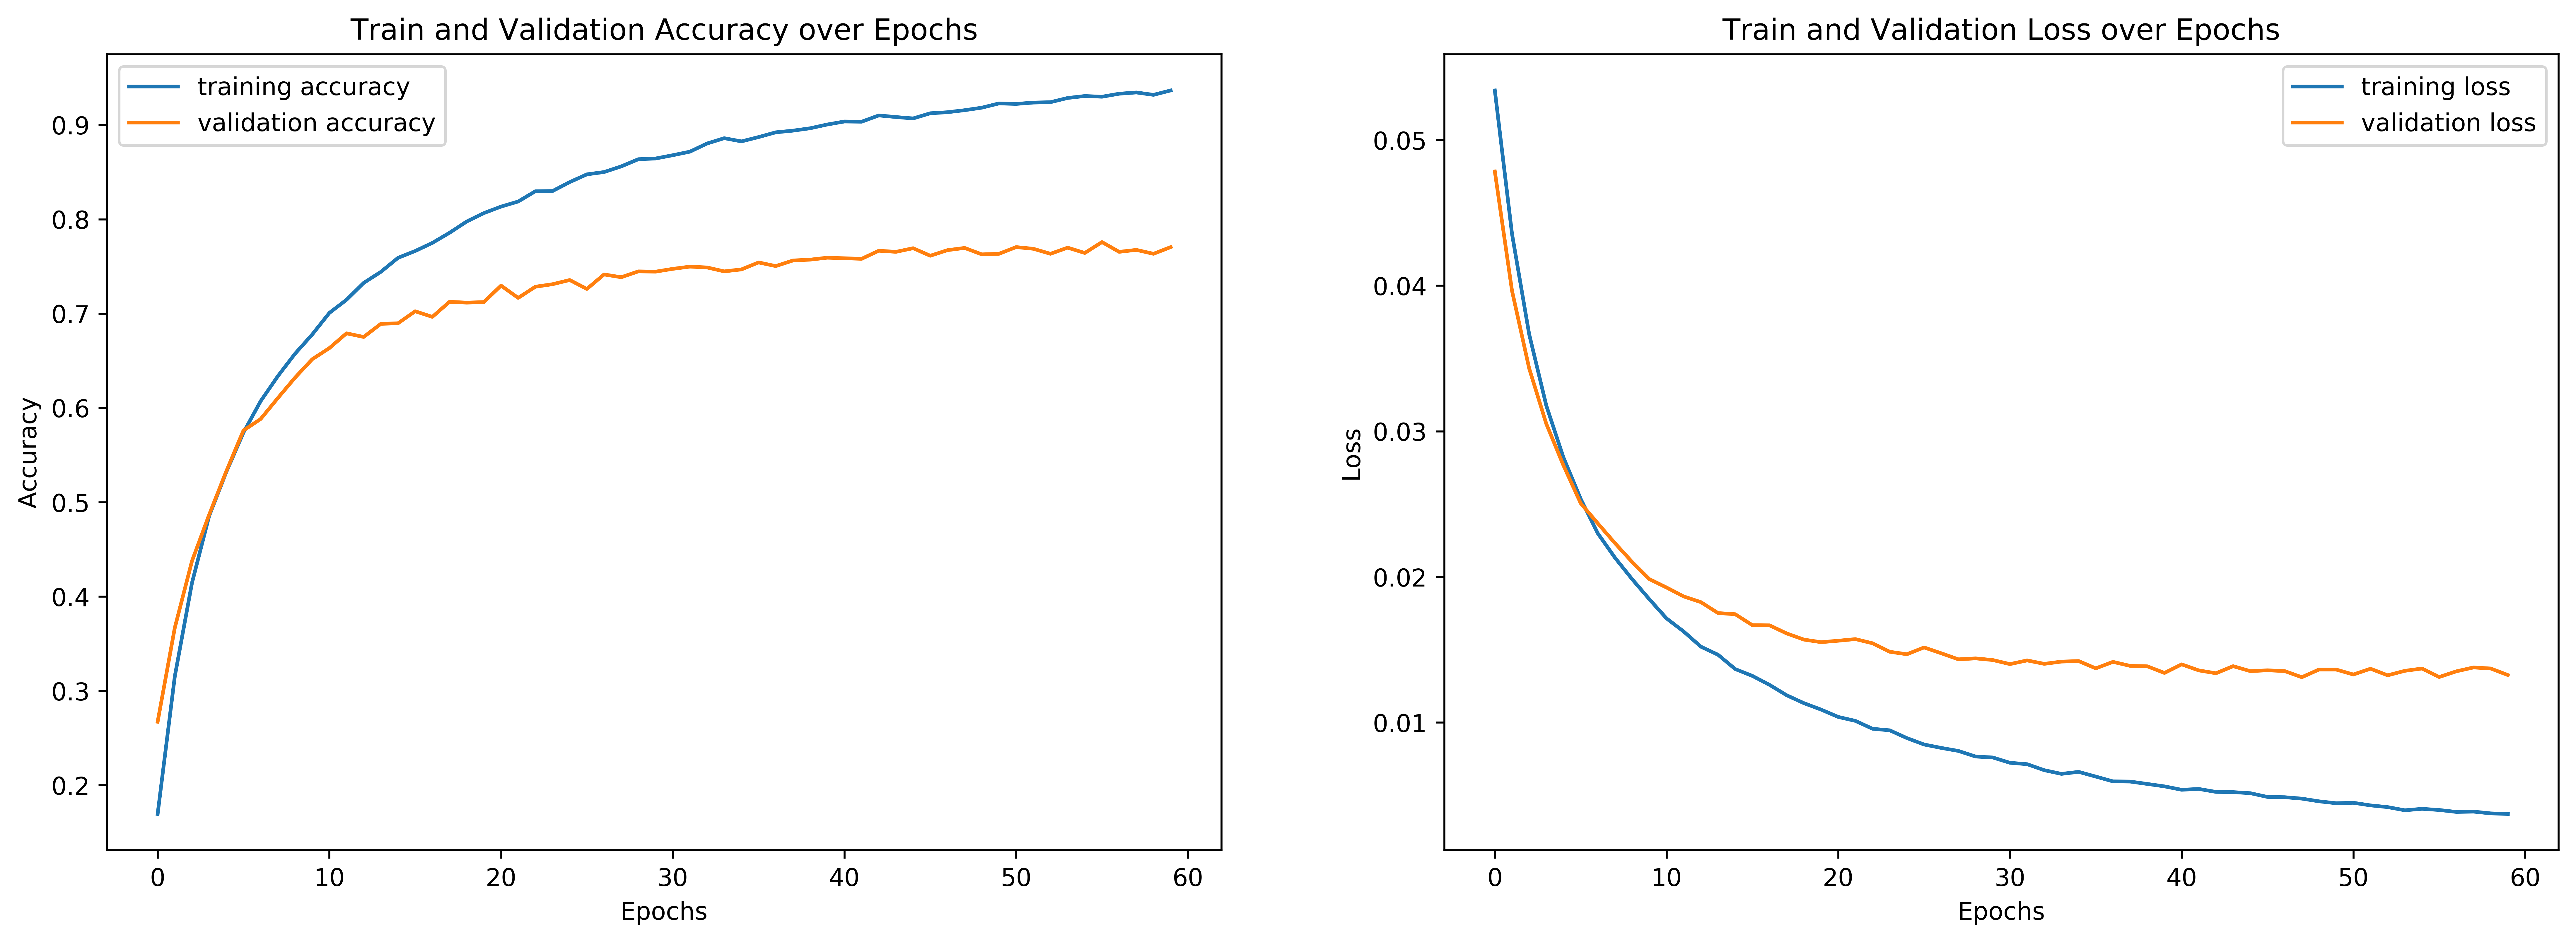

In [0]:
all_train_acc = [l[1] for l in train_ls_acc]
all_train_loss = [l[0] for l in train_ls_acc]
all_val_acc = [l[1] for l in valid_ls_acc]
all_val_loss = [l[0] for l in valid_ls_acc]
plot_result(all_train_acc,all_val_acc,all_train_loss,all_val_loss)

In [0]:
import time
while True:
  time.sleep(1)

KeyboardInterrupt: ignored